<img src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg">

# Journey to Data Scientist : le cas Ulule

## Import des données

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import csv
from scipy.stats import pearsonr,spearmanr
from datetime import datetime


pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("./ulule_data.csv", low_memory=False)

In [81]:
data = df.copy(deep=True)

## Vérification du set de données

Dans la mesure où certains projets peuvent ou non avoir une vidéo de présentation, il est exclu de retirer toute ligne contenant un "NaN" représentant un vide. On se contente donc de retirer les doublons et les colonnes constantes, dans un premier temps.

In [82]:
data.drop_duplicates(inplace=True)  # Retrait de doublons.
data = data.loc[:, (data != data.iloc[0]).any()]  # Retrait de colonnes constantes

## Première analyse du set

Le set contient près de 50000 lignes correspondant à des projets, réussis ou non, et 96 colonnes contenant différents éléments comme le montant levé ou la description du projet dans différentes langues.

<b>A FAIRE : GROUPER LES FEATURES DE MANIERE PERTINENTE ET PARLER DE CHAQUE GROUPE (genre les langues ensemble etc). Faire de petites stats sur ces groupes (ex : nbr de descriptions pour chaque langue)
En tirer les conclusions permettant de justifier les drop de colonnes dans la partie nettoyage.</b>

Les colonnes peuvent être groupées en quatre catégories :
- les données construites par Ulule (comme des listes d'urls)
- les données obsolètes ou constantes et qui seront retirées
- les données liées au projet (avant le lancement)
- les données liées à la campagne (après le lancement)

### Données construites par Ulule

Ces données sont indépendantes du possesseur du projet et ne seront donc pas utilisées dans cette étude.
- absolute_url
- discussion_thread_id
- resource_uri
- urls
- user_role

L'id du projet fait aussi partie du projet mais sera conservé pour disposer d'une variable indépendante du projet et simple à représenter, en abscisse notamment.

### Données obsolètes ou inutiles

Ces données proviennent d'anciennes versions de l'API ou sont constantes quelque soit le projet et sont donc à retirer.

- address_required
- permissions
- phone_number_required
- required_personal_id_number
- image

### Données du projet

Ces données concerne le projet après son lancement.

<b>TODO : expliquer ce qu'on garde ou non, si besoin à l'aide de stats (genre lowest_contrib_amount c'est quasi toujours 1 -> dégage)</b>
- amount_raised
- comments_count
- committed
- finished
- date_end
- date_end_extra_time
- date_goal_raised
- date_start
- fans_count
- is_cancelled
- is_in_extra_time
- is_online
- lowest_contribution_amount
- nb_days
- nb_products_sold
- news_count
- orders_count
- percent
- sponsorships_count
- supporters_count
- status
- time_left
- time_left_short

### Données du projet

Ces données concernent le projet avant son lancement.

<b>TODO : expliquer ce qu'on garde et pourquoi, si besoin à l'aide de stats (par exemple beaucoup plus de projets FR -> retirer les autres).</b>
- analytics_count
- background
- comments_enabled
- country
- currency
- currency_display
- delivery
- description_LANGUE
- description_funding_LANGUE
- goal
- goal_raised
- image
- lang
- location
- main_image
- main_tag
- name_LANGUE
- owner
- payment_methods
- rewards
- slug
- sponsorships_count
- subtitle_LANGUE
- visible
- video
- type
- timezone

## Nettoyage du set

### A REFAIRE SVP
De manière générale, les projets sont en écrasante majorité uniquement en français.
"absolute_url", l'URL d'un projet est retirée car non pertinente.
"is_cancelled" est bien sûr retiré car un projet annulé n'a aucune chance d'être un succès.


"image" est laissée, et pourra être binarisée (avoir une image ou non) ?
"sponsorships_count" est quasi vide mais gardée car intéressante, pareil pour "fans_count"
"id" est conservée pour l'affichage de graphes
Les colonnes "orders_count" et "nb_products_sold" semblent identiques, il faudra surement en retirer une
Les colonnes "amount_raised" et "committed" semblent identiques, il faudra surement en retirer une
Les colonnes "nb_products_sold" et "supporters_count" semblent identiques car en écrasante majorité les investisseurs ne souhaitent qu'une seule contrepartie. 

Ajout de colonnes :
nombre de new/nombre de jour de campagne
l'id du main_tag

Il y a une grande similitude entre "committed" et "amount_raised". Le premier concerne l'argent levé OU le nombre de préventes, le second concerne uniquement l'argent.

Table des equivalences

Préventes : <b>nb_products_sold</b> ou <b>committed</b> est comparé à <b>goal</b> pour obtenir <b>percent</b>.

Projet : <b>amount_raised</b> ou <b>committed</b> est comparé à <b>goal</b> pour obtenir <b>percent</b>.
###### Conclusion : committed est inutile.

In [83]:
data.drop(columns=['absolute_url',
                   'address_required',
                   'phone_number_required',
                   'comments_enabled',
                   'committed',
                   'country',
                   'currency',
                   'currency_display',
                   'date_end_extra_time',
                   'delivery',
                   'description_ca',
                   'description_de',
                   'description_en',
                   'description_es',
                   'description_it',
                   'description_nl',
                   'description_pt',
                   'description_funding_ca',
                   'description_funding_de',
                   'description_funding_en',
                   'description_funding_es',
                   'description_funding_it',
                   'description_funding_nl',
                   'description_funding_pt',
                   'description_yourself_ca',
                   'description_yourself_de',
                   'description_yourself_en',
                   'description_yourself_es',
                   'description_yourself_it',
                   'description_yourself_nl',
                   'description_yourself_pt',
                   'discussions_thread_id',
                   'image',
                   'main_image',
                   'is_cancelled',
                   'is_in_extra_time',
                   'finished',
                   'lang',
                   'lowest_contribution_amount',
                   'name_ca',
                   'name_de',
                   'name_en',
                   'name_es',
                   'name_it',
                   'name_nl',
                   'name_pt',
                   'orders_count',
                   'required_personal_id_number',
                   'resource_uri',
                   'sharing_urls',
                   'slug',
                   'subtitle_ca',
                   'subtitle_de',
                   'subtitle_en',
                   'subtitle_es',
                   'subtitle_it',
                   'subtitle_nl',
                   'subtitle_pt',
                   'time_left', 
                   'time_left_short',
                   'timezone',
                   'urls',
                   'user_role'], inplace=True)

Certaines colonnes doivent être binarisée pour représenter ou non la présence d'un objet (comme une vidéo).

In [84]:
def binarize(x):
    return 1 if type(x) == str else 0

data.background = data.background.apply(binarize)
data.video = data.video.apply(binarize)

La colonne owner est inutilisable en tant que telle car seules les stats de l'owner nous intéressent.

In [145]:
def recup_in_str(x):
    return ast.literal_eval(x['owner'])['stats']
    

data['owner'] = data.apply(recup_in_str, axis = 1)

ValueError: malformed node or string: {'created_projects_online_count': 1, 'followed_projects_count': 0, 'supported_projects_count': 0}

Certaines colonnes sont essentielles, il faut donc retirer toute ligne ne possédant aucune valeur dans l'une de ces colonnes.

In [85]:
essentials_columns_names = ['date_start', 'date_end', 'amount_raised', 'comments_count', 'date_start', 'date_end', 'description_fr',
       'description_funding_fr', 'description_yourself_fr', 'fans_count',
       'goal', 'goal_raised', 'id', 'main_tag', 'name_fr', 'news_count', 'owner', 'percent',
       'rewards', 'sponsorships_count', 'subtitle_fr', 'supporters_count']

for col_name in essentials_columns_names:
    index = data.columns.get_loc(col_name)
    index_with_nan = data.index[data.iloc[:,index].isnull()]
    print("Retrait de {} lignes n'ayant aucun valeur dans la colonne {}".format(len(index_with_nan), col_name))
    data.drop(labels=index_with_nan, inplace=True)

Retrait de 58 lignes n'ayant aucun valeur dans la colonne date_start
Retrait de 0 lignes n'ayant aucun valeur dans la colonne date_end
Retrait de 0 lignes n'ayant aucun valeur dans la colonne amount_raised
Retrait de 0 lignes n'ayant aucun valeur dans la colonne comments_count
Retrait de 0 lignes n'ayant aucun valeur dans la colonne date_start
Retrait de 0 lignes n'ayant aucun valeur dans la colonne date_end
Retrait de 2833 lignes n'ayant aucun valeur dans la colonne description_fr
Retrait de 883 lignes n'ayant aucun valeur dans la colonne description_funding_fr
Retrait de 490 lignes n'ayant aucun valeur dans la colonne description_yourself_fr
Retrait de 0 lignes n'ayant aucun valeur dans la colonne fans_count
Retrait de 0 lignes n'ayant aucun valeur dans la colonne goal
Retrait de 0 lignes n'ayant aucun valeur dans la colonne goal_raised
Retrait de 0 lignes n'ayant aucun valeur dans la colonne id
Retrait de 66 lignes n'ayant aucun valeur dans la colonne main_tag
Retrait de 13 lignes n

La colonne "nb_days" contient un tiers de valeurs vides, il faut la compléter.

In [86]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

data['nb_days'] = [days_between(data.date_start[k][0:10], data.date_end[k][0:10]) for k in data.date_start.index]

Les projets fonctionnent différemment selon qu'ils concernent des préventes ou une financement. Il convient donc de séparer le set en deux sous-sets.

In [155]:
data_presolds = data[data['type'] == 1]
data = data[data['type'] == 2]

data.drop(columns="nb_products_sold", inplace=True) # Strictement équivalent au nombre de participants

## Statistiques descriptives (à revoir et trier, certaines doivent aller avant le nettoyage)

In [88]:
def pie_feature(feature_name, title):
    plt.figure()
    plt.suptitle(title)
    valeurs = data[feature_name].value_counts() #on compte le nombre de personnes qui ont chaque feature
    plt.pie(valeurs, labels=valeurs.index, autopct='%1.2f%%')
    plt.show()
    
def plot_feature(feature_name, title, xlabel, ylabel):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    plt.suptitle(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.plot(data.id, data[feature_name], "+")

    sns.boxplot(y=data[feature_name], ax=ax2)
    ax2.set_ylabel("")
    plt.show()

##### fans_count

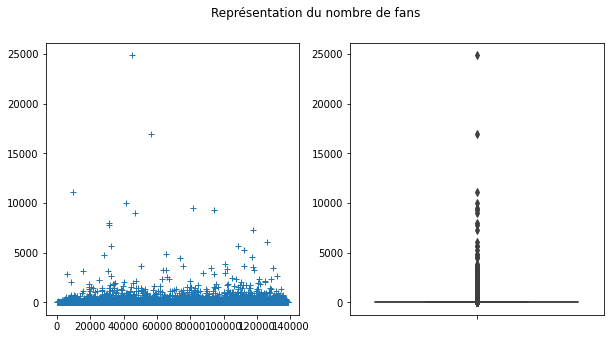

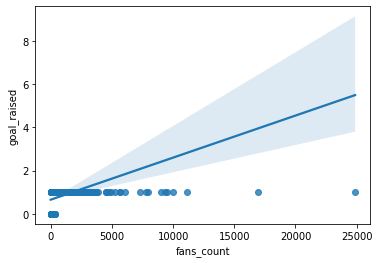

SpearmanrResult(correlation=0.2360795542470868, pvalue=0.0)

In [90]:
plot_feature("fans_count", "Représentation du nombre de fans","","")

plt.figure()
sns.regplot(x="fans_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['fans_count'])


La présence de fans semble être un phénomène très minoritaire, il serait intéressant de vérifier si les projets suivis ont été plus réussis que les autres.
Il est possible de conclure quand à l'existence d'une corrélation entre le succès de la campagne et le nombre de fans.

##### goal_raised

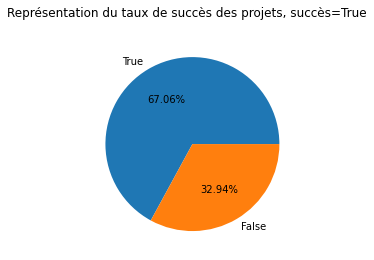

In [93]:
pie_feature("goal_raised", "Représentation du taux de succès des projets, succès=True")

Pour rappel, le taux de succès des projets de la plateforme en 2021 est de 79%.

##### payment_methods

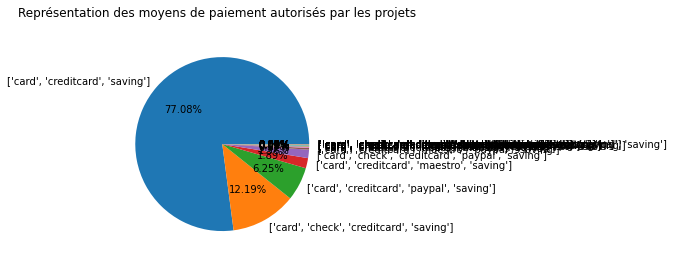

SpearmanrResult(correlation=nan, pvalue=nan)

In [95]:
pie_feature("payment_methods", "Représentation des moyens de paiement autorisés par les projets")

spearmanr(data['goal_raised'], data['payment_methods'])

La totalité autorise le trio "card, creditcard, saving" et 75% l'utilisent.
Il ne semble y avoir aucune corrélation entre le moyen de paiement et le succès de la campagne.

##### sponsorships_count

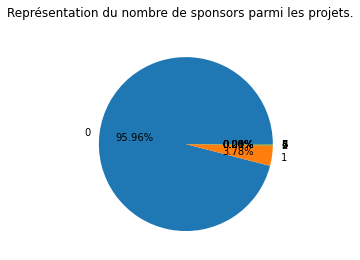

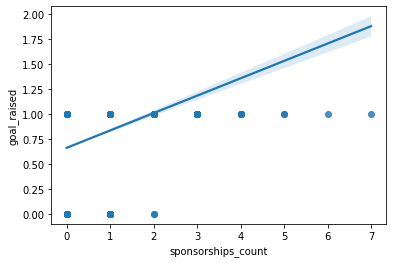

SpearmanrResult(correlation=0.08599151607121658, pvalue=1.1121983086349011e-72)

In [96]:
pie_feature("sponsorships_count", "Représentation du nombre de sponsors parmi les projets.")

plt.figure()
sns.regplot(x="sponsorships_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['sponsorships_count'])

L'obtention de sponsors semble être un phénomène très minoritaire.
Il ne semble pas y avoir de corrélation entre le succès de la campagne et la présence de sponsors.

##### main_tag

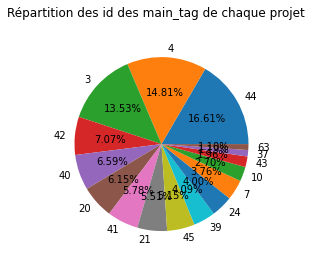

SpearmanrResult(correlation=-0.024203210946109496, pvalue=4.0549668365475515e-07)

In [103]:
tag_list = [ast.literal_eval(data["main_tag"][k])["id"] for k in data["main_tag"].index]
data["main_tag_id"] = tag_list
pie_feature("main_tag_id", "Répartition des id des main_tag de chaque projet")
spearmanr(data['goal_raised'], data['main_tag'])

Il ne semble pas y avoir une corrélation entre le tag du projet et son succès.

##### amount_raised

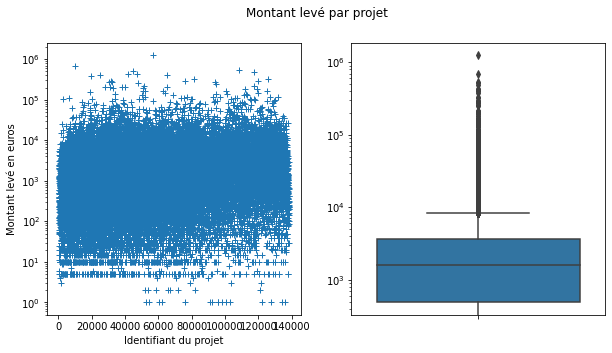

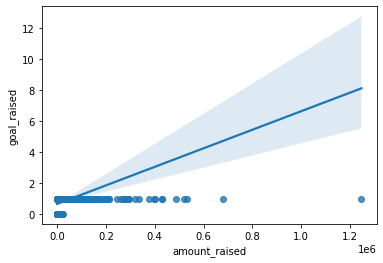

SpearmanrResult(correlation=0.6717716018750167, pvalue=0.0)

In [108]:
def plot_feature_log(feature_name, title, xlabel, ylabel):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    plt.suptitle(title)
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.plot(data.id, data[feature_name], "+")

    sns.boxplot(y=data[feature_name], ax=ax2)
    ax2.set_ylabel("")
    plt.show()

plot_feature_log("amount_raised", "Montant levé par projet", "Identifiant du projet", "Montant levé en euros")

plt.figure()
sns.regplot(x="amount_raised", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['amount_raised'])

Les projets semblent assez homogènes dans les montants levés même si moins nombreux pour les plus hauts montants.
Il semble y avoir une bonne corrélation entre le montant obtenu et le succès de la campagne (peu surprenant).

##### comments_count

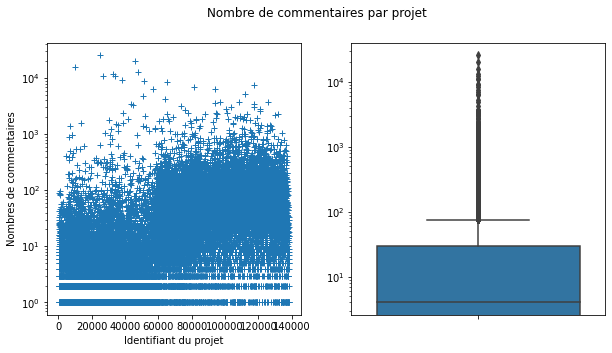

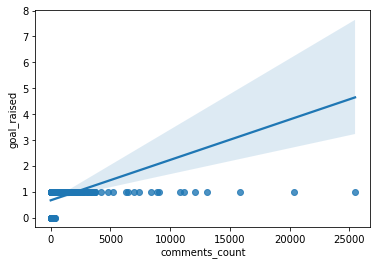

SpearmanrResult(correlation=0.3473641551725862, pvalue=0.0)

In [109]:
plot_feature_log("comments_count", "Nombre de commentaires par projet", "Identifiant du projet", "Nombres de commentaires")

plt.figure()
sns.regplot(x="comments_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['comments_count'])

Les projets reçoivent globalement assez peu de commentaires. La plupart des projets qui ont beaucoup de commentaires, ont bien fonctionné.
Il semble y avoir une petite corrélation entre le nombre de commentaires et le succès de la campagne.

##### goal

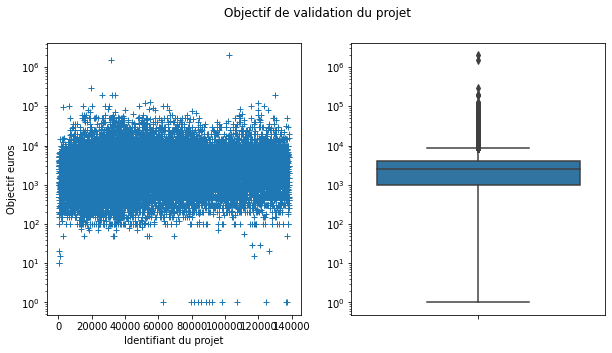

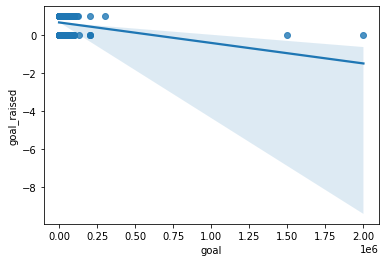

SpearmanrResult(correlation=-0.07973539912681564, pvalue=1.0216540107651168e-62)

In [110]:
plot_feature_log("goal", "Objectif de validation du projet", "Identifiant du projet", "Objectif euros")

plt.figure()
sns.regplot(x="goal", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['goal'])

La majorité des projets semble se concentrer autour de la même fourchette de valeur, malgré quelques valeurs extrêmes.
Il ne semble pas y avoir de corrélation entre le montant de succès de la campagne et son succès.

##### nb_days

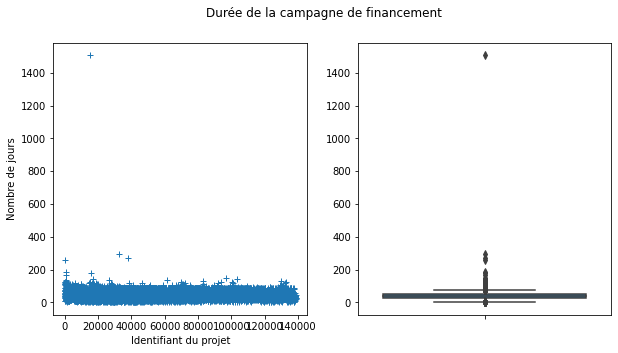

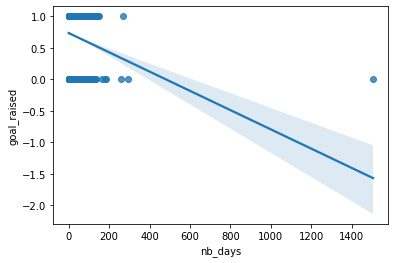

SpearmanrResult(correlation=-0.05907302510007453, pvalue=3.590792469352454e-35)

In [111]:
plot_feature("nb_days", "Durée de la campagne de financement", "Identifiant du projet", "Nombre de jours")

plt.figure()
sns.regplot(x="nb_days", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['nb_days'])

Les campagnes semblent durer plus ou moins un mois en grande majorité.
Il ne semble n'y avoir aucune corrélation entre la durée de la campagne et son succès.

##### news_count

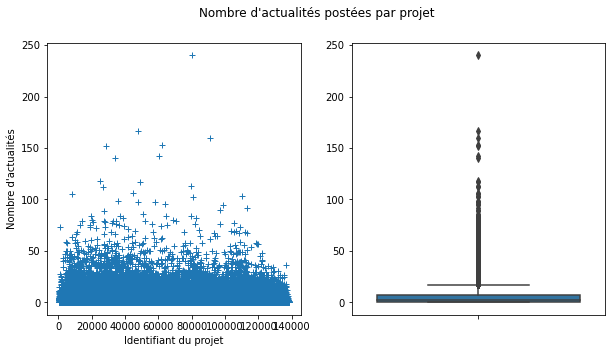

3        0.152778
4        0.000000
5        0.000000
7        0.160000
9        0.022222
           ...   
52202    0.000000
52203    0.083333
52204    0.033333
52205    0.000000
52206    0.000000
Length: 43807, dtype: float64


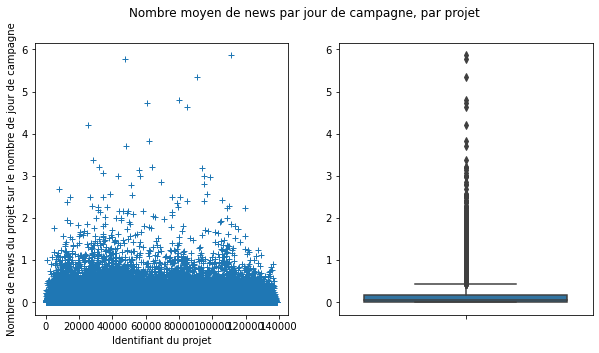

/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


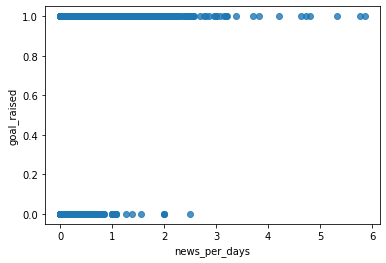

SpearmanrResult(correlation=0.46078032743555825, pvalue=0.0)

In [113]:
plot_feature("news_count", "Nombre d'actualités postées par projet", "Identifiant du projet", "Nombre d'actualités")
col = (data["news_count"]/data["nb_days"]).apply(lambda x : 0 if np.isnan(x) else x)
data["news_per_days"] = col

plot_feature("news_per_days", "Nombre moyen de news par jour de campagne, par projet","Identifiant du projet","Nombre de news du projet sur le nombre de jour de campagne")

plt.figure()
sns.regplot(x="news_per_days", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['news_per_days'])

Un certain nombre de projets ne donne aucune nouvelle durant la campagne, la grande majorité n'en donne pas plus de cinq durant toute la campagne. La grande majorité des projets ne donne qu'une news tous les dix jours, au mieux.
Il semble y avoir une légère corrélation entre le nombre de news par jour et le succès de la campagne.

##### percent

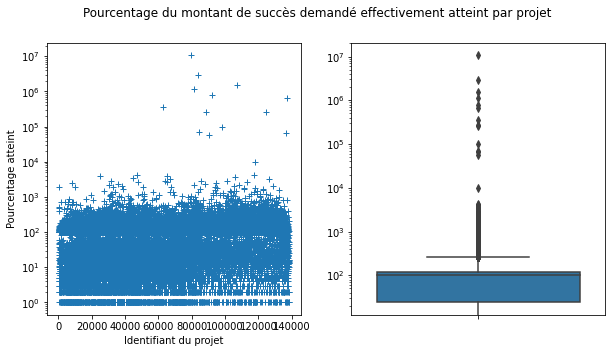

In [123]:
plot_feature_log("percent", "Pourcentage du montant de succès demandé effectivement atteint par projet", "Identifiant du projet", "Pourcentage atteint")

On note trois catégories de projets : 
- ceux qui échouent complétement (moins de 50% du montant demandé sont atteints)
- ceux qui réussissent "normalement" (entre 100% et 175% du montant demandé sont atteints)
- ceux qui réussissent "fortement" (au-delà de 200%)

##### supporters_count

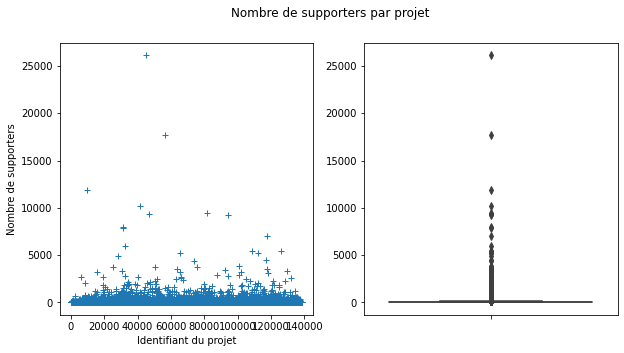

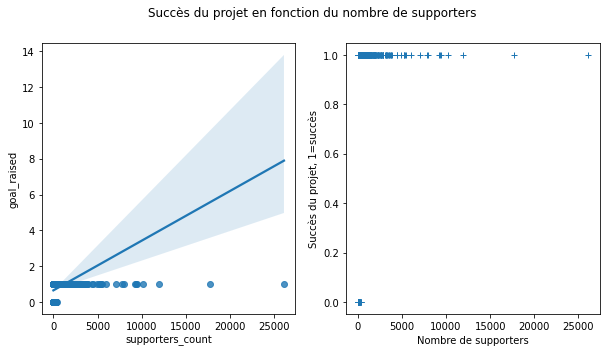

SpearmanrResult(correlation=0.6816500878949846, pvalue=0.0)

In [124]:
plot_feature("supporters_count", "Nombre de supporters par projet", "Identifiant du projet", "Nombre de supporters")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="supporters_count", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction du nombre de supporters")
ax2.set_xlabel("Nombre de supporters")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data.supporters_count, data.goal_raised, "+")
plt.show()

spearmanr(data['goal_raised'],data['supporters_count'])

On constate une bonne corrélation entre le succès du projet et le nombre de supporters.

##### analytics_count

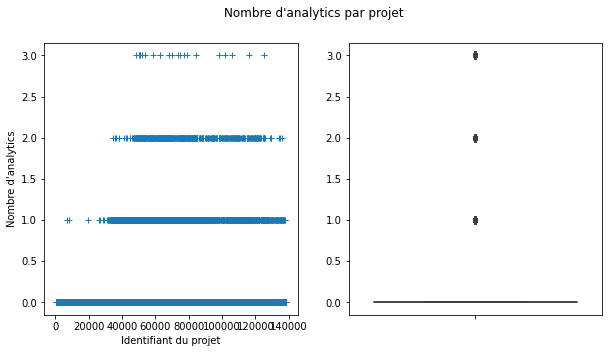

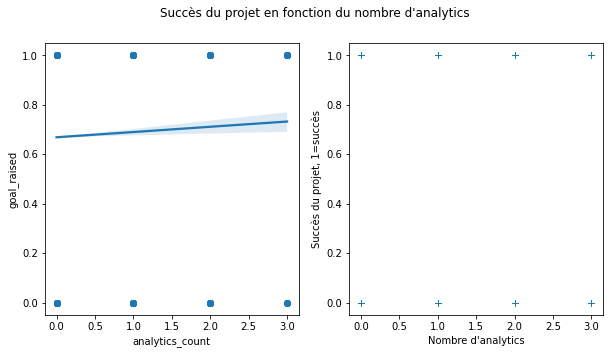

SpearmanrResult(correlation=0.007330216576392867, pvalue=0.12498043527965406)

In [125]:
plot_feature("analytics_count", "Nombre d'analytics par projet", "Identifiant du projet", "Nombre d'analytics")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="analytics_count", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction du nombre d'analytics")
ax2.set_xlabel("Nombre d'analytics")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data.analytics_count, data.goal_raised, "+")
plt.show()

spearmanr(data['goal_raised'],data['analytics_count'])

On constate qu'il n'y a pas de corrélation entre le nombre d'analytics et la réussite d'un projet

##### type

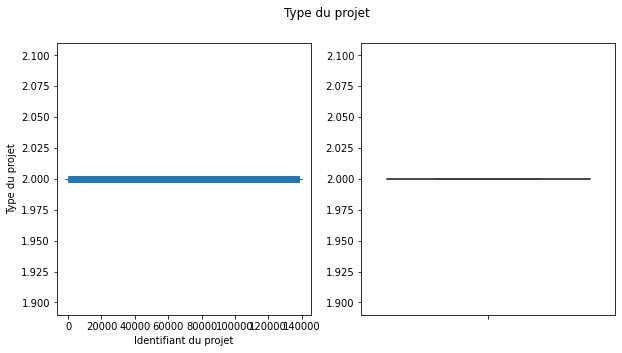

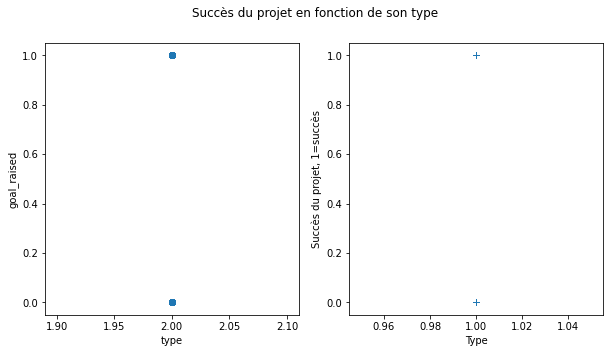

/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


SpearmanrResult(correlation=nan, pvalue=nan)

In [127]:
plot_feature("type", "Type du projet", "Identifiant du projet", "Type du projet")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="type", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction de son type")
ax2.set_xlabel("Type")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data_presolds.type, data_presolds.goal_raised, "+")
plt.show()

#spearmanr(data['goal_raised'],data['type'])

Les projets de type préventes sont très minoritaires. 
Il n'y a pas de corrélation entre le type et le succès d'un projet.

##### visible

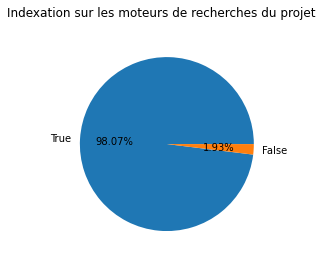

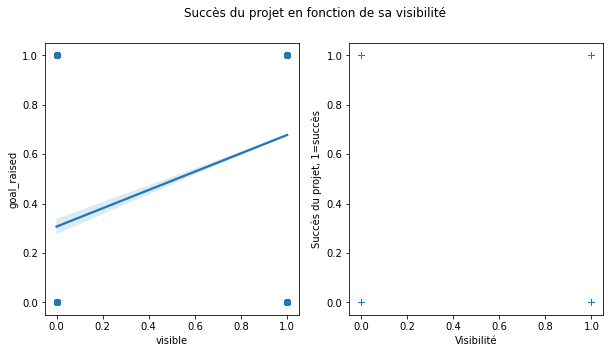

SpearmanrResult(correlation=0.10862050701974826, pvalue=4.456726324750813e-115)

In [129]:
pie_feature("visible", "Indexation sur les moteurs de recherches du projet")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="visible", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction de sa visibilité")
ax2.set_xlabel("Visibilité")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data.visible, data.goal_raised, "+")
plt.show()

spearmanr(data['goal_raised'],data['visible'])

La plupart des projets sont indexés sur les moteurs de recherches.
On ne constate cepandant pas de corrélation entre la visibilité et le succès d'un projet

##### video

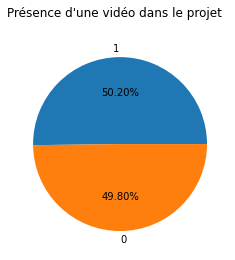

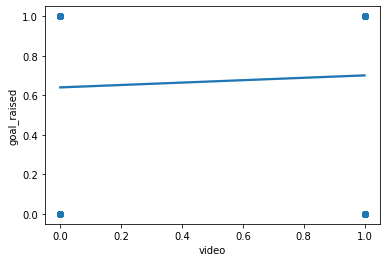

SpearmanrResult(correlation=0.06464386064863048, pvalue=8.61885073663394e-42)

In [130]:
pie_feature("video", "Présence d'une vidéo dans le projet")

plt.figure()
sns.regplot(x="video", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['video'])

Il ne semble pas y avoir de corrélation entre le fait de posséder une vidéo et le succès de la campagne

##### main_image (à bouger probablement)

In [131]:
pie_feature("main_image", "Présence d'une image principale dans le projet")

plt.figure()
sns.regplot(x="main_image", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['main_image'])

KeyError: 'main_image'

<Figure size 432x288 with 0 Axes>

Tous les projets ont une image principale, colonne non pertinente.

##### date_end_extra_time (preuve de non intérêt)

In [136]:
pie_feature("date_end_extra_time", "Extension de la durée de la campagne")

plt.figure()
sns.regplot(x="date_end_extra_time", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['date_end_extra_time'])

KeyError: 'date_end_extra_time'

<Figure size 432x288 with 0 Axes>

La colonne date_end_extra_time sera retirée car aucun projet ayant échoué n'y a fait appel et c'est un phénomène très minoritaire.

##### background

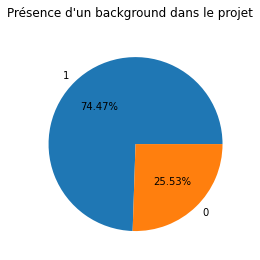

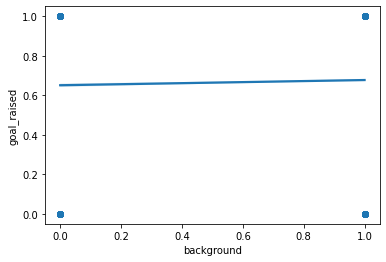

SpearmanrResult(correlation=0.02444772041470123, pvalue=3.0951940314753894e-07)

In [137]:
pie_feature("background", "Présence d'un background dans le projet")

plt.figure()
sns.regplot(x="background", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['background'])

Il n'y a pas de corrélation entre la présence d'un background et le succès de la campagne.

## A FAIRE

Enlever les extrêmes

Faire des trucs avec: les dates, main_tag, rewards

Owner: garder stats uniquement

Mettre à jour ci-dessous \/

/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


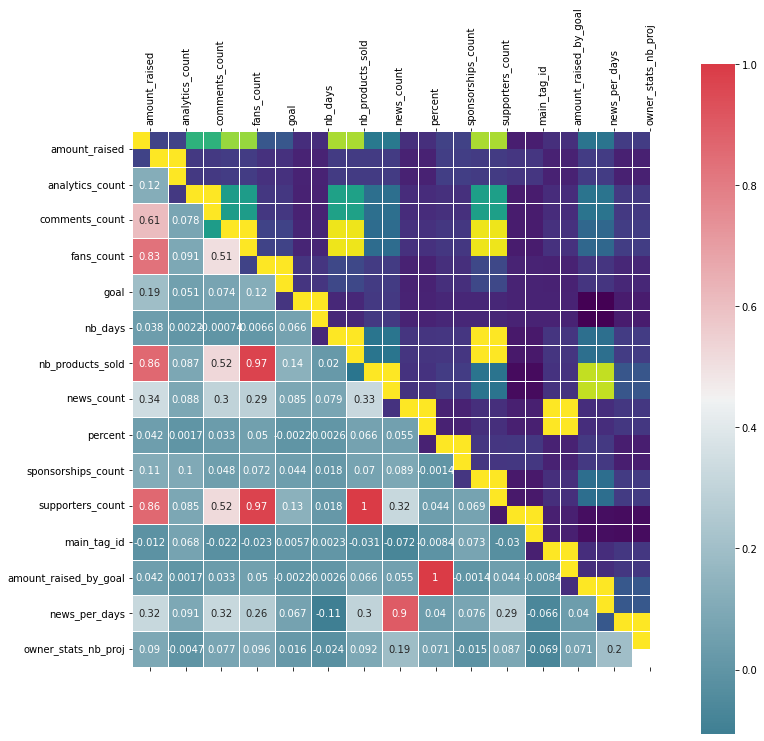

In [153]:
corr_df = data.copy(deep=True)
corr_df.drop(columns=['id', 'type', 'background', 'date_goal_raised', 'date_start', 'description_fr', 'description_funding_fr', 'description_yourself_fr', 'goal_raised', 'location', 'main_tag', 'name_fr', 'owner', 'payment_methods', 'rewards', 'subtitle_fr', 'video', 'visible'], inplace=True)
plt.matshow(corr_df.corr())

def plot_corr(corr):
    plt.rc('figure', figsize=[12, 12])
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, linewidth=0.5, square=True)
    plt.show()

plot_corr(corr_df.corr())